<a href="https://colab.research.google.com/github/NinaOmani/S2S_Precipitation_Forecasting/blob/main/B_Categorical_S2S_PRCP_Forecast_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Regression Prediction Model**

In [ ]:
!pip install pandas numpy scikit-learn scipy matplotlib
!pip install gdown

In [ ]:
import os
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib import patches as mpatches
from matplotlib.lines import Line2D
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV


In [ ]:
# Define a region
regions = ["AZ_West", "AZ_East", "NM_South", "NM_North"]

# **Hindcast**

**Use those trained models to:**
*   **Predict ECMWF hindcasts using .for predictors (for years 1993–2018).** \
the hindcast predictions on ECMWF forecast data (i.e., the ecmwf-hindcast step in our Python version) use a model trained on .obs data (observed predictor vs observed precipitation from 1993–2018), and then apply that model to ECMWF forecast data (.for) for the same period (1993–2018).
*   **Predict ECMWF forecasts (out-of-sample years, 2019–2023).**

ECMWF hindcast evaluation (linR2_ECMWF)
Out-of-sample prediction evaluation (for years > 2018)

In [ ]:
# Re-import necessary packages due to code execution environment reset
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.lines import Line2D
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.formula.api as smf

In [ ]:

# Define the custom season order
custom_season_order = ['Jun', 'Jul', 'Aug', 'Sep', 'Oct',
                       'JJ', 'JA', 'AS', 'SO',
                       'JJA', 'JAS', 'ASO', 'JASO', 'JJASO']

# Define single-month and aggregated-month season sets
single_month_seasons = {'Jun', 'Jul', 'Aug', 'Sep', 'Oct'}
aggregated_month_seasons = set(custom_season_order) - single_month_seasons

In [ ]:
# Load the newly uploaded dataset to verify and apply the fix
predictors = pd.read_csv("Predictors.csv")

# Add ENSO indices to the list of columns to fill
antecedent_cols_extended = [
    "antecedent_3m.for", "antecedent_2m.for", "antecedent_1m.for",
    "antecedent_3m.obs", "antecedent_2m.obs", "antecedent_1m.obs",
    "ant_dsst3.4.for", "ant_mei.for", "ant_soi.for",
    "ant_dsst3.4.obs", "ant_mei.obs", "ant_soi.obs"
]

agg_season_mapping = {
    "JJ": "Jun", "JA": "Jun", "AS": "Aug", "SO": "Sep",
    "JJA": "Jun", "JAS": "Jul", "ASO": "Aug", "JASO": "Jul", "JJASO": "Jun"
}

# Re-apply filling logic for these extended columns
for agg_season, base_month in agg_season_mapping.items():
    for (region, year), group in predictors.groupby(["region", "year"]):
        agg_mask = (predictors["region"] == region) & (predictors["year"] == year) & (predictors["season"] == agg_season)
        base_mask = (predictors["region"] == region) & (predictors["year"] == year) & (predictors["season"] == base_month)

        if agg_mask.any() and base_mask.any():
            for col in antecedent_cols_extended:
                if predictors.loc[agg_mask, col].isna().all() and predictors.loc[base_mask, col].notna().any():
                    predictors.loc[agg_mask, col] = predictors.loc[base_mask, col].values[0]

predictors.to_csv("Predictors_filled.csv", index=False)

In [ ]:
# Load data
Predictors_filled = pd.read_csv("Predictors_filled.csv")
#min_year, max_year = 1981, 2022  # For 16-year rolling time serires plots
min_year, max_year = 1993, 2018 # For prediction

# MLR

In [ ]:


# Define multi-predictor models
combined_model_specs = {
    "multi_linear1": ["sumMonsoon.obs", "sumDry.obs"],
    "multi_linear2": ["sumq.obs", "antecedent_3m.obs"],
    "multi_linear3": ["sumMonsoon.obs", "sumDry.obs", "antecedent_3m.obs"]
}

ecmwf_gof = []
gof_training = []
ecmwf_results = []

for model_key, predictors in combined_model_specs.items():
    df_model = Predictors_filled[["region", "season", "year", "lead_month", "avgPCP_mmDay"] + predictors].dropna()

    for region in df_model["region"].unique():
        for season in df_model["season"].unique():
            df_train = df_model[
                (df_model["region"] == region) &
                (df_model["season"] == season) &
                (df_model["year"] >= min_year) & (df_model["year"] <= max_year)
            ].copy()

            if df_train.empty:
                continue

            safe_names = {p: p.replace(".", "_") for p in predictors}
            norm_means = {p: df_train[p].mean() for p in predictors}
            norm_stds = {p: df_train[p].std() for p in predictors}

            skip = False
            for p in predictors:
                if pd.isna(norm_stds[p]) or norm_stds[p] == 0:
                    skip = True
                    break
                df_train[f"x_{safe_names[p]}"] = (df_train[p] - norm_means[p]) / norm_stds[p]
            if skip:
                continue

            x_cols = [f"x_{safe_names[p]}" for p in predictors]
            y_mean = df_train["avgPCP_mmDay"].mean()
            y_std = df_train["avgPCP_mmDay"].std()
            df_train["y"] = (df_train["avgPCP_mmDay"] - y_mean) / y_std

            model = LinearRegression()
            model.fit(df_train[x_cols], df_train["y"])

            y_pred = model.predict(df_train[x_cols])
            y_pred_rescaled = y_pred * y_std + y_mean
            r2 = r2_score(df_train["avgPCP_mmDay"], y_pred_rescaled)

            # Predictions already computed above: y_pred_rescaled
            rmse_train = np.sqrt(mean_squared_error(df_train["avgPCP_mmDay"], y_pred_rescaled))
            rmse_clim = np.sqrt(mean_squared_error(df_train["avgPCP_mmDay"], [y_mean] * len(df_train)))

            # Append RMSE (model) and RMSE_clim (baseline) to training GOF
            # Append training R²
            gof_training.append({
                'region': region,
                'season': season,
                'model': "MLR",
                'lead_month': "NA",
                'statlong': 'R2_MLR_train',
                'stat': 'R2',
                'value': r2,
                'stat_obs': r2,
                'stat_obs_xval': "NA",
                'detrend': False,
                'norm': True,
                "predictor": "+".join(p for p in predictors),
                'xval': False,
                'xnormMean': str({p: round(norm_means[p], 4) for p in predictors}),
                'xnormSD': str({p: round(norm_stds[p], 4) for p in predictors}),
                'ynormMean': y_mean,
                'ynormSD': y_std,
                'coef1': model.intercept_,
                'coef2': model.coef_[0] if len(model.coef_) > 0 else 0.0,
                'coef3': model.coef_[1] if len(model.coef_) > 1 else 0.0,
            })

            # Append training RMSE and climatology RMSE
            gof_training.extend([
                {
                    'region': region,
                    'season': season,
                    'model': "MLR",
                    'lead_month': "NA",
                    'statlong': 'RMSE_train',
                    'stat': 'RMSE',
                    'value': rmse_train,
                    'predictor': "+".join(p for p in predictors),
                },
                {
                    'region': region,
                    'season': season,
                    'model': "climatology",
                    'lead_month': "NA",
                    'statlong': 'RMSE_clim',
                    'stat': 'RMSE',
                    'value': rmse_clim,
                    'predictor': "+".join(p for p in predictors),
                }
            ])

            # --- Hindcast ---
            df_hind = Predictors_filled[
                (Predictors_filled["region"] == region) & (Predictors_filled["season"] == season) &
                (Predictors_filled["year"] >= min_year) & (Predictors_filled["year"] <= max_year)
            ].copy()

            for lead in sorted(df_hind["lead_month"].dropna().unique()):
                df_lead = df_hind[df_hind["lead_month"] == lead].copy()
                predictor_for = [p.replace(".obs", ".for") for p in predictors]
                df_lead = df_lead.dropna(subset=predictor_for + ["avgPCP_mmDay"])
                if df_lead.empty:
                    continue

                norm_means_for = {}
                norm_stds_for = {}
                for_norm = pd.DataFrame(index=df_lead.index)

                skip_lead = False
                for p in predictors:
                    p_for = p.replace(".obs", ".for")
                    mean = df_lead[p_for].mean()
                    std = df_lead[p_for].std()
                    if pd.isna(std) or std == 0:
                        skip_lead = True
                        break
                    norm_means_for[p_for] = mean
                    norm_stds_for[p_for] = std
                    for_norm[f"x_{safe_names[p]}"] = (df_lead[p_for] - mean) / std
                if skip_lead:
                    continue

                y_pred = model.predict(for_norm[x_cols])
                y_pred_rescaled = y_pred * y_std + y_mean
                r2_hind = r2_score(df_lead["avgPCP_mmDay"], y_pred_rescaled)

                # Compute RMSE for hindcast
                rmse_hind = np.sqrt(mean_squared_error(df_lead["avgPCP_mmDay"], y_pred_rescaled))
                rmse_clim_lead = np.sqrt(mean_squared_error(df_lead["avgPCP_mmDay"], [y_mean] * len(df_lead)))


                # Append R² for ECMWF hindcast
                ecmwf_gof.append({
                    "region": region,
                    "season": season,
                    "model": "MLR",
                    "lead_month": lead,
                    "statlong": f'R2_ECMWF_lead{lead}',
                    "stat": "R2",
                    "value": r2_hind,
                    "stat_obs": r2,
                    "stat_obs_xval": "NA",
                    "detrend": False,
                    "norm": True,
                    "predictor": "+".join(p.replace(".obs", ".for") for p in predictors),
                    "xval": False,
                    "xnormMean": str({p: round(norm_means_for[p.replace(".obs", ".for")], 4) for p in predictors}),
                    "xnormSD": str({p: round(norm_stds_for[p.replace(".obs", ".for")], 4) for p in predictors}),
                    "ynormMean": y_mean,
                    "ynormSD": y_std,
                    "coef1": model.intercept_,
                    "coef2": model.coef_[0] if len(model.coef_) > 0 else 0.0,
                    "coef3": model.coef_[1] if len(model.coef_) > 1 else 0.0
                })

                # Append RMSE (model and climatology) for ECMWF hindcast
                ecmwf_gof.extend([
                    {
                        "region": region,
                        "season": season,
                        "model": "MLR",
                        "lead_month": lead,
                        "statlong": f'RMSE_ECMWF_lead{lead}',
                        "stat": "RMSE",
                        "value": rmse_hind,
                        "predictor": "+".join(p.replace(".obs", ".for") for p in predictors),
                    },
                    {
                        "region": region,
                        "season": season,
                        "model": "climatology",
                        "lead_month": lead,
                        "statlong": f'RMSE_clim_lead{lead}',
                        "stat": "RMSE",
                        "value": rmse_clim_lead,
                        "predictor": "+".join(p.replace(".obs", ".for") for p in predictors),
                    }
                ])
                for i, row in enumerate(df_lead.itertuples(index=False)):
                  ecmwf_results.append({
                      "region": region,
                      "season": season,
                      "model": "MLR",
                      "predictor": "+".join(predictor_for),  # Convert list to string like "sumMonsoon.for+sumDry.for"
                      "predictor_value": [float(v) for v in df_lead.iloc[i][predictor_for].values],
                      "year": row.year,
                      "lead_month": row.lead_month,
                      "type": "ecmwf-hindcast",
                      "observed": row.avgPCP_mmDay,
                      "predicted": y_pred_rescaled[i],
                })


# Convert lists of dictionaries to DataFrames
gof_training_df = pd.DataFrame(gof_training)
gof_hindcast_df = pd.DataFrame(ecmwf_gof)

# Save to CSV
gof_training_df.to_csv("GOF_training_results.csv", index=False)
gof_hindcast_df.to_csv("GOF_ECMWF_hindcast_results.csv", index=False)

ecmwf_MLR = pd.DataFrame(ecmwf_results)
ecmwf_path = "ecmwf_predictionsMLR.csv"
ecmwf_MLR.to_csv(ecmwf_path, index=False)


# SLR, Binom, Propodds

In [ ]:


predictors = ["sumMonsoon.obs", "sumDry.obs", "sumtclw.obs", "sumq.obs", "sumtprate.obs","ant_soi.obs","ant_mei.obs","ant_dsst3.4.obs","antecedent_1m.obs","antecedent_2m.obs","antecedent_3m.obs"]

linear_result = []
obs_fit_data = []
ecmwf_results = []
ecmwf_gof = []
processed_models = set()

for predictor_obs in predictors:
    # Drop NaNs only for this specific predictor and avgPCP_mmDay
    obs_df = Predictors_filled[["region", "season", "year", "avgPCP_mmDay", predictor_obs]].dropna().drop_duplicates()


    for region in obs_df["region"].unique():  # region = "AZ_East"    season = "SO"
        for season in obs_df["season"].unique():

            key = (region, season, predictor_obs)
            if key in processed_models:
                continue
            processed_models.add(key)

            df_train = obs_df[
                (obs_df["region"] == region) &
                (obs_df["season"] == season) &
                (obs_df["year"] >= min_year) &
                (obs_df["year"] <= max_year)
            ].copy()

            if df_train.empty:
                continue

            # Normalize
            x_mean = df_train[predictor_obs].mean()
            x_std = df_train[predictor_obs].std()
            y_mean = df_train["avgPCP_mmDay"].mean()
            y_std = df_train["avgPCP_mmDay"].std()

            df_train["x"] = (df_train[predictor_obs] - x_mean) / x_std
            df_train["y"] = (df_train["avgPCP_mmDay"] - y_mean) / y_std

            if df_train["x"].isna().any() or df_train["y"].isna().any():
                continue

            model = LinearRegression()
            model.fit(df_train[["x"]], df_train["y"])

            df_train["y_pred"] = model.predict(df_train[["x"]])
            df_train["y_pred_rescaled"] = df_train["y_pred"] * y_std + y_mean

            for _, row in df_train.iterrows():
                obs_fit_data.append({
                    "region": region, "season": season, "year": row["year"], "predictor": predictor_obs,
                    "predictor_value": row[predictor_obs], "observed": row["avgPCP_mmDay"],
                    "predicted": row["y_pred"], "predicted_rescaled": row["y_pred_rescaled"]
                })


            # Compute model performance metrics (in-sample)
            y_obs = df_train["avgPCP_mmDay"].values
            y_pred_insample = df_train["y_pred_rescaled"].values
            y_clim = np.mean(y_obs)

            mse_lm = mean_squared_error(y_obs, y_pred_insample)
            mse_clim = mean_squared_error(y_obs, np.full_like(y_obs, y_clim))
            mae_lm = mean_absolute_error(y_obs, y_pred_insample)
            mae_clim = mean_absolute_error(y_obs, np.full_like(y_obs, y_clim))
            rmse_clim = np.sqrt(mse_clim)
            rmse_lm = np.sqrt(mse_lm)
            r2_lm = r2_score(y_obs, y_pred_insample)
            skill_improvement = 1 - mse_lm / mse_clim if mse_clim != 0 else np.nan

            # Calculate the quantiles
            Q50 = df_train['avgPCP_mmDay'].median()
            Q33 = df_train['avgPCP_mmDay'].quantile(0.3333)
            Q66 = df_train['avgPCP_mmDay'].quantile(0.6666)

            y_n = len(df_train['y'])

            # Compute quantiles
            zQuant = df_train['y'].quantile([0.3333, 0.6666])
            T1 = zQuant.iloc[0]  # Q33
            T2 = zQuant.iloc[1]  # Q66

            # Median
            zMed = df_train['y'].median()

            # Create binomial response initialized with a placeholder (not necessary in pandas but included for similarity)
            y_binom = np.full(y_n, -999)

            # Assign categories based on the median
            y_binom[df_train['y'] <= zMed] = 0
            y_binom[df_train['y'] > zMed] = 1

            # Compute proportions
            p1_clim_bi = np.sum(y_binom == 0) / y_n
            p2_clim_bi = np.sum(y_binom == 1) / y_n

            # Display category proportions
            binomial_summary = pd.DataFrame(
                [[round(p1_clim_bi, 2), round(p2_clim_bi, 2)]],
                columns=["Cat0", "Cat1"]
            )

            print("##########################binomial_summary###########################")
            print(binomial_summary)

            # Create multinomial response initialized with a placeholder
            y_log = np.full(y_n, -999)

            # Assign categories based on thresholds T1 and T2
            y_log[df_train['y'] <= T1] = 1       # Cat 1
            y_log[(df_train['y'] > T1) & (df_train['y'] < T2)] = 2  # Cat 2
            y_log[df_train['y'] >= T2] = 3       # Cat 3

            # Ensure integer type for comparison
            y_log = y_log.astype(int)

            # Compute proportions
            p1_clim = np.sum(y_log == 1) / y_n
            p2_clim = np.sum(y_log == 2) / y_n
            p3_clim = np.sum(y_log == 3) / y_n
            climo = [p1_clim, p2_clim, p3_clim]

            # Display category proportions
            multinomial_summary = pd.DataFrame(
                [[round(p1_clim, 2), round(p2_clim, 2), round(p3_clim, 2)]],
                columns=["Cat1", "Cat2", "Cat3"]
            )

            print("##########################multinomial_summary###########################")
            print(multinomial_summary)
            print("########################################################################")

            # Add binomial and multinomial response columns to the DataFrame
            df_train['y_binom'] = y_binom
            df_train['y_multi'] = y_log

            # Fit logistic regression model (binomial family)
            vglm_binom = smf.logit(formula='y_binom ~ x', data=df_train).fit()

            print(vglm_binom.summary())

            from statsmodels.miscmodels.ordinal_model import OrderedModel

            # Ensure y_multi is treated as an ordered categorical variable (1 < 2 < 3)
            df_train['y_multi'] = pd.Categorical(df_train['y_multi'], ordered=True)

            # Fit proportional odds model (ordinal logistic regression)
            vglm_propodds = OrderedModel(
                df_train['y_multi'],
                df_train[['x']],   # predictors
                distr='logit'            # logit link matches 'propodds' in R
            ).fit(method='bfgs')


            print(vglm_propodds.summary())

            # Get fitted probabilities from the binomial logistic model
            yhat_binom = vglm_binom.predict()  # This returns predicted probabilities for y_binom = 1

            # Brier Score
            B_score = np.sum((yhat_binom - df_train['y_binom']) ** 2) / y_n
            B_score_clim = np.sum((p2_clim_bi - df_train['y_binom']) ** 2) / y_n
            BSS = 1 - (B_score / B_score_clim)
            BSS_obs = BSS

            # RPSS
            pred_probs = vglm_propodds.predict(which='prob')
            y_log = df_train['y_multi'].astype(int).values - 1

            rps = 0.0
            rpsc = 0.0
            for i in range(len(y_log)):
                obs = np.zeros(3)
                obs[y_log[i]] = 1
                rps += np.sum((obs - pred_probs[i]) ** 2)
                rpsc += np.sum((obs - climo) ** 2)

            rpss = 1 - (rps / rpsc)
            rpss_obs = rpss
            print("✅ RPSS =", round(rpss, 4))

            # Add RMSE for training
            ecmwf_gof.append({
                'region': region,
                'season': season,
                'model': 'SLR',
                'lead_month': "NA",
                'statlong': 'RMSE_SLR_train',
                'stat': 'RMSE',
                'value': np.sqrt(mse_lm),
                'stat_obs': np.sqrt(mse_lm),
                'stat_obs_xval': "NA",
                'detrend': False,
                'norm': True,
                'predictor': predictor_obs.replace('.obs', ''),
                'xval': False,
                'xnormMean': x_mean,
                'xnormSD': x_std,
                'ynormMean': y_mean,
                'ynormSD': y_std,
                'coef1': model.intercept_,
                'coef2': model.coef_[0],
                'coef3': 0.0,
                'Q50_mmDay': Q50,
                'Q33_mmDay': Q33,
                'Q66_mmDay': Q66
            })

            # Add RMSE for climatology (training)
            ecmwf_gof.append({
                'region': region,
                'season': season,
                'model': 'climatology',
                'lead_month': "NA",
                'statlong': 'RMSE_clim_train',
                'stat': 'RMSE',
                'value': np.sqrt(mse_clim),
                'stat_obs': np.sqrt(mse_clim),
                'stat_obs_xval': "NA",
                'detrend': False,
                'norm': True,
                'predictor': predictor_obs.replace('.obs', ''),
                'xval': False,
                'xnormMean': x_mean,
                'xnormSD': x_std,
                'ynormMean': y_mean,
                'ynormSD': y_std,
                'coef1': 0.0,
                'coef2': 0.0,
                'coef3': 0.0,
                'Q50_mmDay': Q50,
                'Q33_mmDay': Q33,
                'Q66_mmDay': Q66
              })

            linear_result.append({
                'region': region,
                'season': season,
                'model': 'SLR',
                'lead_month': "NA",
                'statlong': 'R2_SLR_train',
                'stat': 'R2',
                'value': r2_lm,
                'stat_obs': r2_lm,
                'stat_obs_xval': "NA",
                'detrend': False,
                'norm': True,
                'predictor': predictor_obs.replace('.obs', ''),
                'xval': False,
                'xnormMean': x_mean,
                'xnormSD': x_std,
                'ynormMean': y_mean,
                'ynormSD': y_std,
                'coef1': model.intercept_,
                'coef2': model.coef_[0],
                'coef3': 0.0,
                'Q50_mmDay': Q50,
                'Q33_mmDay': Q33,
                'Q66_mmDay': Q66
            })
            ecmwf_gof.extend(linear_result)

            # Add the Brier Skill Score (BSS) result for the binomial model
            binom_result = {
                'region': region,
                'season': season,
                'model': 'binom',
                'lead_month': "NA",
                'statlong': 'BSS_train',
                'stat': 'BSS',
                'value': BSS,
                'stat_obs': BSS_obs,
                'stat_obs_xval': "NA",
                'detrend': False,
                'norm': True,
                'predictor': predictor_obs.replace('.obs', ''),
                'xval': False,
                'xnormMean': x_mean,
                'xnormSD': x_std,
                'ynormMean': y_mean,
                'ynormSD': y_std,
                'coef1': vglm_binom.params.iloc[0],
                'coef2': vglm_binom.params.iloc[1],
                'coef3': 0.0,  # Only one predictor in binomial model
                'Q50_mmDay': Q50,
                'Q33_mmDay': Q33,
                'Q66_mmDay': Q66
            }
            ecmwf_gof.append(binom_result)

            # RPSS result already defined above
            propodds_result = {
                'region': region,
                'season': season,
                'model': 'Propodds',
                'lead_month': "NA",
                'statlong': 'RPSS_train',
                'stat': 'RPSS',
                'value': rpss,
                'stat_obs': rpss_obs,
                'stat_obs_xval': "NA",
                'detrend': False,
                'norm': True,
                'predictor': predictor_obs.replace('.obs', ''),
                #"predictor_value": df_lead.iloc[i][predictor_obs],
                'xval': False,
                'xnormMean': x_mean,
                'xnormSD': x_std,
                'ynormMean': y_mean,
                'ynormSD': y_std,
                'coef1': vglm_propodds.params.iloc[2],
                'coef2': vglm_propodds.params.iloc[1],
                'coef3': vglm_propodds.params.iloc[0],
                'Q50_mmDay': Q50,
                'Q33_mmDay': Q33,
                'Q66_mmDay': Q66
            }
            ecmwf_gof.append(propodds_result)
############################################################################################
            predictor_for = predictor_obs.replace(".obs", ".for")

            # Hindcast prediction
            df_hindcast_sub = Predictors_filled[
                (Predictors_filled["region"] == region) &
                (Predictors_filled["season"] == season) &
                (Predictors_filled["year"] >= min_year) &
                (Predictors_filled["year"] <= max_year)
            ].copy()

            lead_months = df_hindcast_sub["lead_month"].unique()

            for lead in lead_months:
              df_lead = df_hindcast_sub[df_hindcast_sub["lead_month"] == lead].copy()
              df_lead = df_lead.dropna(subset=["avgPCP_mmDay", predictor_for])
              print(df_lead[[predictor_for, "avgPCP_mmDay"]].describe())

              if df_lead.empty:
                  continue

              # Normalize
              X_for = df_lead[[predictor_for]]
              x_mean_lead = X_for.mean().values[0]
              x_std_lead = X_for.std().values[0]
              X_for_norm = (X_for - x_mean_lead) / x_std_lead
              X_for_norm.columns = ["x"]
              if X_for_norm.isna().any().values[0]:
                  continue

              # Skip if standard deviation is zero or NaN
              if pd.isna(x_std_lead) or x_std_lead == 0:
                  print(f"⚠️ Skipping {predictor_for} for {region}-{season}, lead {lead} due to NaN or zero std")
                  continue

              print(f"🧪 Any NaNs in original: {X_for.isna().any().values[0]}, after norm: {X_for_norm.isna().any().values[0]}")

              # Linear prediction
              y_pred = model.predict(X_for_norm)
              y_actual = df_lead["avgPCP_mmDay"].values
              y_pred_rescaled = y_pred * y_std + y_mean
              df_lead["y"] = (df_lead["avgPCP_mmDay"] - y_mean) / y_std

              y_n_hindcast = len(df_lead)
              # Predict probabilities for class 1 using the binomial model
              y_binom_hind = np.where(df_lead["y"] <= zMed, 0, 1)
              y_hat_binom_lead = vglm_binom.predict(X_for_norm)  # 'x' must be normalized predictor column

              # Compute Brier score for the model
              bs_model_hindcast = np.mean((y_hat_binom_lead - y_binom_hind) ** 2)

              # Compute Brier score for climatology (p2_clim_bi = proportion of class 1 in training)
              bs_clim_hindcast = np.mean((p2_clim_bi - y_binom_hind) ** 2)
              # Brier Skill Score
              bss_hindcast = 1 - (bs_model_hindcast / bs_clim_hindcast)
              print("✅ Brier Skill Score (BSS):", round(bss_hindcast, 4))
              #############################################################################################
              # Multinomial (propodds) category probabilities
              y_hat_multi_lead = vglm_propodds.predict(X_for_norm, which='prob')

              #  y_hat_multi_lead is the predicted probabilities for each class from the hindcast
              # and y_log_hindcast is the multinomial category labels for the hindcast data
              # climo is the climatological probabilities for each category

              # Compute multinomial labels for hindcast data
              y_log_hindcast = np.full(len(df_lead), -999)
              y_log_hindcast[df_lead["y"] <= T1] = 1
              y_log_hindcast[(df_lead["y"] > T1) & (df_lead["y"] < T2)] = 2
              y_log_hindcast[df_lead["y"] >= T2] = 3
              y_log_hindcast = y_log_hindcast.astype(int) - 1 # Convert to 0-based

              # Initialize variables
              rps = 0.0
              rpsc = 0.0

              # Loop over all hindcast instances
              for i in range(y_n_hindcast):
                  obs = np.zeros(3)
                  obs[y_log_hindcast[i]] = 1  # Convert to 0-based indexing
                  probs = y_hat_multi_lead.iloc[i].values  # Convert to NumPy array
                  rps += np.sum((obs - probs) ** 2)
                  rpsc += np.sum((obs - climo) ** 2)

              rpss_hindcast = 1 - (rps / rpsc)
              print("✅ RPSS (forecast) =", round(rpss_hindcast, 4))

              #r2 = np.corrcoef(y_actual, y_pred_rescaled)[0, 1] ** 2
              #r21 = np.corrcoef(y_actual, y_pred)[0, 1] ** 2
              r2 = r2_score(y_actual, y_pred_rescaled)

              def smape(a, f):
                  """Symmetric mean absolute percentage error (SMAPE), expressed in percentage."""
                  return 100 * np.mean(2 * np.abs(f - a) / (np.abs(a) + np.abs(f) + 1e-8))

              # Prediction error metrics
              mse_lm = mean_squared_error(y_actual, y_pred_rescaled)
              mae_lm = mean_absolute_error(y_actual, y_pred_rescaled)
              mbe_lm = np.mean(y_pred_rescaled - y_actual)

              y_clim = np.full_like(y_actual, np.mean(y_actual))
              mae_clim = mean_absolute_error(y_actual, y_clim)
              mbe_clim = np.mean(y_clim - y_actual)
              mse_clim = mean_squared_error(y_actual, y_clim)
              rmse_lm = np.sqrt(mse_lm)
              rmse_clim = np.sqrt(mse_clim)

              skill = 1 - mse_lm / mse_clim

              # SMAPE calculations
              smape_lm = smape(y_actual, y_pred_rescaled)
              smape_clim = smape(y_actual, np.full_like(y_actual, np.mean(y_actual)))


              # Add RMSE for hindcast
              ecmwf_gof.append({
                  'region': region,
                  'season': season,
                  'model': 'SLR',
                  'lead_month': lead,
                  'statlong': f'RMSE_ECMWF_lead{lead}',
                  'stat': 'RMSE',
                  'value': rmse_lm,
                  'stat_obs': np.sqrt(mse_lm),
                  'stat_obs_xval': "NA",
                  'detrend': False,
                  'norm': True,
                  'predictor': predictor_for,
                  'xval': False,
                  'xnormMean': x_mean_lead,
                  'xnormSD': x_std_lead,
                  'ynormMean': y_mean,
                  'ynormSD': y_std,
                  'coef1': model.intercept_,
                  'coef2': model.coef_[0],
                  'coef3': 0.0,
                  'Q50_mmDay': Q50,
                  'Q33_mmDay': Q33,
                  'Q66_mmDay': Q66
              })


              # Add RMSE for climatology (hindcast)
              ecmwf_gof.append({
                  'region': region,
                  'season': season,
                  'model': 'climatology',
                  'lead_month': lead,
                  'statlong': f'RMSE_clim_lead{lead}',
                  'stat': 'RMSE',
                  'value': rmse_clim,
                  'stat_obs': rmse_clim,
                  'stat_obs_xval': "NA",
                  'detrend': False,
                  'norm': True,
                  'predictor': predictor_for,
                  'xval': False,
                  'xnormMean': x_mean_lead,
                  'xnormSD': x_std_lead,
                  'ynormMean': y_mean,
                  'ynormSD': y_std,
                  'coef1': 0.0,
                  'coef2': 0.0,
                  'coef3': 0.0,
                  'Q50_mmDay': Q50,
                  'Q33_mmDay': Q33,
                  'Q66_mmDay': Q66
              })

              ecmwf_gof.append({
                  'region': region,
                  'season': season,
                  'model': 'SLR',
                  'lead_month': lead,
                  'statlong': f'R2_ECMWF_lead{lead}',
                  'stat': 'R2',
                  'value': r2,
                  'stat_obs': r2_lm,
                  'stat_obs_xval': "NA",
                  'detrend': False,
                  'norm': True,
                  'predictor': predictor_for,
                  'xval': False,
                  'xnormMean': x_mean_lead,
                  'xnormSD': x_std_lead,
                  'ynormMean': y_mean,
                  'ynormSD': y_std,
                  'coef1': model.intercept_,
                  'coef2': model.coef_[0],
                  'coef3': 0.0,
                  'Q50_mmDay': Q50,
                  'Q33_mmDay': Q33,
                  'Q66_mmDay': Q66
              })


              # Binomial model prediction
              ecmwf_gof.append({
                  'region': region,
                  'season': season,
                  'model': 'binom',
                  'lead_month': lead,
                  'statlong': f'BSS_ECMWF_lead{int(lead)}',
                  'stat': 'BSS',
                  'value': bss_hindcast,
                  'stat_obs': BSS_obs,
                  'stat_obs_xval': "NA",
                  'detrend': False,
                  'norm': True,
                  'predictor': predictor_for,
                  'xval': False,
                  'xnormMean': x_mean_lead,
                  'xnormSD': x_std_lead,
                  'ynormMean': y_mean,
                  'ynormSD': y_std,
                  'coef1': vglm_binom.params.iloc[0],
                  'coef2': vglm_binom.params.iloc[1],
                  'coef3': 0.0,
                  'Q50_mmDay': Q50,
                  'Q33_mmDay': Q33,
                  'Q66_mmDay': Q66
              })

              # Multinomial model prediction
              ecmwf_gof.append({
                  'region': region,
                  'season': season,
                  'model': 'Propodds',
                  'lead_month': lead,
                  'statlong': f'RPSS_ECMWF_lead{int(lead)}',
                  'stat': 'RPSS',
                  'value': rpss_hindcast,
                  'stat_obs': rpss_obs,
                  'stat_obs_xval': "NA",
                  'detrend': False,
                  'norm': True,
                  'predictor': predictor_for,
                  'xval': False,
                  'xnormMean': x_mean_lead,
                  'xnormSD': x_std_lead,
                  'ynormMean': y_mean,
                  'ynormSD': y_std,
                  'coef1': vglm_propodds.params.iloc[2],
                  'coef2': vglm_propodds.params.iloc[1],
                  'coef3': vglm_propodds.params.iloc[0],
                  'Q50_mmDay': Q50,
                  'Q33_mmDay': Q33,
                  'Q66_mmDay': Q66
              })


              for i, row in enumerate(df_lead.itertuples(index=False)):
                  ecmwf_results.append({
                      "region": region,
                      "season": season,
                      "model": "SLR",
                      "predictor": predictor_for,
                      "predictor_value": df_lead.iloc[i][predictor_for],
                      "year": row.year,
                      "lead_month": row.lead_month,
                      "type": "ecmwf-hindcast",
                      "observed": row.avgPCP_mmDay,
                      "predicted": y_pred_rescaled[i],
                  })


            # # Out-of-sample (2019–2023)
            # df_oos = df[(df["region"] == region) & (df["season"] == season) &
            #             (df["year"] > max_year) & (df["year"] <= 2023)].copy()

            # if not df_oos.empty and predictor_for in df_oos.columns:
            #     for lead in df_oos["lead_month"].unique():
            #         df_lead_oos = df_oos[df_oos["lead_month"] == lead].copy()
            #         df_lead_oos = df_lead_oos.dropna(subset=[predictor_for, "avgPCP_mmDay"])
            #         if df_lead_oos.empty:
            #             continue

            #         # Get hindcast stats for normalization
            #         df_lead_hind = df_hindcast_sub[df_hindcast_sub["lead_month"] == lead].copy()
            #         x_mean_lead = df_lead_hind[predictor_for].mean()
            #         x_std_lead = df_lead_hind[predictor_for].std()

            #         print(f"🧾 OOS: lead {lead}, x_mean: {x_mean_lead}, x_std: {x_std_lead}")

            #         # Skip if invalid stats
            #         if pd.isna(x_mean_lead) or pd.isna(x_std_lead) or x_std_lead == 0:
            #             print(f"⚠️ Skipping {predictor_for} for {region}-{season} OOS, lead {lead} due to NaN or 0 std")
            #             continue

            #         X_oos = df_lead_oos[[predictor_for]]
            #         if X_oos.isna().any().values[0]:
            #             print(f"⚠️ Skipping due to NaNs in raw X_oos at lead {lead}")
            #             continue

            #         X_oos_norm = (X_oos - x_mean_lead) / x_std_lead
            #         X_oos_norm.columns = ["x"]

            #         if X_oos_norm.isna().any().values[0]:
            #             print(f"⚠️ Skipping due to NaNs in normalized X_oos at lead {lead}")
            #             continue

            #         try:
            #             y_pred_oos = model.predict(X_oos_norm)
            #         except Exception as e:
            #             print(f"🚨 OOS prediction error at lead {lead}: {e}")
            #             continue


            #         y_pred_oos = model.predict(X_oos_norm)
            #         y_oos = df_lead_oos["avgPCP_mmDay"].values
            #         y_pred_oos_rescaled = y_pred_oos * y_std + y_mean

            #         mse_oos = mean_squared_error(y_oos, y_pred_oos_rescaled)
            #         #r2_oos = np.corrcoef(y_oos, y_pred_oos_rescaled)[0, 1] ** 2 if len(y_oos) > 1 else None
            #         r2_oos = r2_score(y_oos, y_pred_oos_rescaled)

            #         mse_clim = mean_squared_error(y_oos, np.full_like(y_oos, np.mean(y_oos)))
            #         skill_oos = 1 - (mse_oos / mse_clim) if mse_clim > 0 else None

            #         for i, row in enumerate(df_lead_oos.itertuples(index=False)):
            #             ecmwf_results.append({
            #                 "region": region,
            #                 "season": season,
            #                 'model': 'SLR',
            #                 "predictor": predictor_for,
            #                 "predictor_value": df_lead_oos.iloc[i][predictor_for],  # ✅ fixed here too
            #                 "year": row.year,
            #                 "lead_month": row.lead_month,
            #                 "type": "ecmwf-out-of-sample",
            #                 "observed": row.avgPCP_mmDay,
            #                 "predicted": y_pred_oos_rescaled[i],
            #             })

# Save outputs

ecmwf_df = pd.DataFrame(ecmwf_results)
ecmwf_gof_df = pd.DataFrame(ecmwf_gof)

ecmwf_path = "ecmwf_predictions.csv"
ecmwf_gof_path = "ecmwf_gof.csv"

ecmwf_df.to_csv(ecmwf_path, index=False)
ecmwf_gof_df.to_csv(ecmwf_gof_path, index=False)


##########################binomial_summary###########################
   Cat0  Cat1
0   0.5   0.5
##########################multinomial_summary###########################
   Cat1  Cat2  Cat3
0  0.35  0.31  0.35
########################################################################
Optimization terminated successfully.
         Current function value: 0.660357
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                y_binom   No. Observations:                   26
Model:                          Logit   Df Residuals:                       24
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Jun 2025   Pseudo R-squ.:                 0.04731
Time:                        06:21:48   Log-Likelihood:                -17.169
converged:                       True   LL-Null:                       -18.022
Covariance Type:            nonrobust   LLR p-value:         

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


✅ Brier Skill Score (BSS): -0.1149
✅ RPSS (forecast) = 0.0746
##########################binomial_summary###########################
   Cat0  Cat1
0   0.5   0.5
##########################multinomial_summary###########################
   Cat1  Cat2  Cat3
0  0.35  0.31  0.35
########################################################################
         Current function value: 0.572445
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                y_binom   No. Observations:                   26
Model:                          Logit   Df Residuals:                       24
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Jun 2025   Pseudo R-squ.:                  0.1741
Time:                        06:21:50   Log-Likelihood:                -14.884
converged:                      False   LL-Null:                       -18.022
Covariance Type:            nonrobu

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


✅ RPSS (forecast) = 0.0403
##########################binomial_summary###########################
   Cat0  Cat1
0   0.5   0.5
##########################multinomial_summary###########################
   Cat1  Cat2  Cat3
0  0.35  0.31  0.35
########################################################################
Optimization terminated successfully.
         Current function value: 0.671611
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                y_binom   No. Observations:                   26
Model:                          Logit   Df Residuals:                       24
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Jun 2025   Pseudo R-squ.:                 0.03107
Time:                        06:21:52   Log-Likelihood:                -17.462
converged:                       True   LL-Null:                       -18.022
Covariance Type:            nonrob

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Streaming output truncated to the last 5000 lines.
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Jun 2025   Pseudo R-squ.:                  0.2901
Time:                        06:22:01   Log-Likelihood:                -12.795
converged:                       True   LL-Null:                       -18.022
Covariance Type:            nonrobust   LLR p-value:                  0.001223
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0976      0.491      0.199      0.842      -0.865       1.060
x             -1.7822      0.720     -2.476      0.013      -3.193      -0.371
Optimization terminated successfully.
         Current function value: 0.882534
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
                             OrderedModel Results                 

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packa

Streaming output truncated to the last 5000 lines.
                           Logit Regression Results                           
Dep. Variable:                y_binom   No. Observations:                   26
Model:                          Logit   Df Residuals:                       24
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Jun 2025   Pseudo R-squ.:                  0.4220
Time:                        06:22:24   Log-Likelihood:                -10.417
converged:                       True   LL-Null:                       -18.022
Covariance Type:            nonrobust   LLR p-value:                 9.622e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1991      0.577     -0.345      0.730      -1.330       0.932
x              2.2786      0.837      2.721      0.007       0.637       3.920
O

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect sepa

         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                y_binom   No. Observations:                   26
Model:                          Logit   Df Residuals:                       24
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Jun 2025   Pseudo R-squ.:                   1.000
Time:                        06:22:33   Log-Likelihood:            -4.8672e-13
converged:                      False   LL-Null:                       -18.022
Covariance Type:            nonrobust   LLR p-value:                 1.929e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    186.2543   9.21e+06   2.02e-05      1.000   -1.81e+07    1.81e+07
x            925.4499   4.59e+07   2.02e-05      1.000   -8.99e+0

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


       sumtprate.for  avgPCP_mmDay
count   2.600000e+01     26.000000
mean    1.299088e-08      0.826264
std     1.701006e-09      0.386372
min     9.633635e-09      0.062302
25%     1.207255e-08      0.661225
50%     1.293175e-08      0.735140
75%     1.453083e-08      1.111486
max     1.636479e-08      1.688797
🧪 Any NaNs in original: False, after norm: False
✅ Brier Skill Score (BSS): -0.1624
✅ RPSS (forecast) = -0.1909
       sumtprate.for  avgPCP_mmDay
count   2.600000e+01     26.000000
mean    1.109264e-08      0.826264
std     1.669864e-09      0.386372
min     7.404026e-09      0.062302
25%     1.008107e-08      0.661225
50%     1.104333e-08      0.735140
75%     1.210722e-08      1.111486
max     1.456089e-08      1.688797
🧪 Any NaNs in original: False, after norm: False
✅ Brier Skill Score (BSS): -0.4148
✅ RPSS (forecast) = -0.592
       sumtprate.for  avgPCP_mmDay
count   2.600000e+01     26.000000
mean    9.271572e-09      0.826264
std     3.372561e-09      0.386372
min    

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


       sumtprate.for  avgPCP_mmDay
count   2.600000e+01     26.000000
mean    3.662247e-08      0.563340
std     5.648051e-09      0.193215
min     2.935794e-08      0.217479
25%     3.225995e-08      0.402175
50%     3.477908e-08      0.529193
75%     3.942708e-08      0.732279
max     4.996706e-08      0.860630
🧪 Any NaNs in original: False, after norm: False
✅ Brier Skill Score (BSS): -0.5385
✅ RPSS (forecast) = -0.3889
##########################binomial_summary###########################
   Cat0  Cat1
0   0.5   0.5
##########################multinomial_summary###########################
   Cat1  Cat2  Cat3
0  0.35  0.31  0.35
########################################################################
Optimization terminated successfully.
         Current function value: 0.193468
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                y_binom   No. Observations:                   26
Model:                       

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packa

       sumtprate.for  avgPCP_mmDay
count   2.600000e+01     26.000000
mean    1.104560e-09      0.109297
std     3.559340e-10      0.116445
min     5.971880e-10      0.000593
25%     8.550870e-10      0.007650
50%     1.046078e-09      0.061089
75%     1.281873e-09      0.182001
max     1.897615e-09      0.383604
🧪 Any NaNs in original: False, after norm: False
✅ Brier Skill Score (BSS): -1.1538
✅ RPSS (forecast) = -0.5145
       sumtprate.for  avgPCP_mmDay
count   2.600000e+01     26.000000
mean    1.055609e-09      0.109297
std     4.134292e-10      0.116445
min     4.137913e-10      0.000593
25%     7.856155e-10      0.007650
50%     9.596615e-10      0.061089
75%     1.235186e-09      0.182001
max     2.456201e-09      0.383604
🧪 Any NaNs in original: False, after norm: False
✅ Brier Skill Score (BSS): -0.6669
✅ RPSS (forecast) = -0.375
       sumtprate.for  avgPCP_mmDay
count   2.600000e+01     26.000000
mean    1.274698e-09      0.109297
std     1.201405e-09      0.116445
min    

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.193454
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
                             OrderedModel Results                             
Dep. Variable:                y_multi   Log-Likelihood:                -5.0298
Model:                   OrderedModel   AIC:                             16.06
Method:            Maximum Likelihood   BIC:                             19.83
Date:                Fri, 06 Jun 2025                                         
Time:                        06:22:36                                         
No. Observations:                  26                                         
Df Residuals:                      23                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Streaming output truncated to the last 5000 lines.
min         4.112838e-09      0.822212
25%         5.936321e-09      1.651609
50%         8.154427e-09      2.038769
75%         1.122049e-08      2.205873
max         1.539195e-08      3.254914
🧪 Any NaNs in original: False, after norm: False
✅ Brier Skill Score (BSS): -0.0217
✅ RPSS (forecast) = 0.003
##########################binomial_summary###########################
   Cat0  Cat1
0   0.5   0.5
##########################multinomial_summary###########################
   Cat1  Cat2  Cat3
0  0.35  0.31  0.35
########################################################################
Optimization terminated successfully.
         Current function value: 0.687475
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                y_binom   No. Observations:                   26
Model:                          Logit   Df Residuals:                       24
Method:              

In [ ]:

combined_all = (
    gof_training +
    ecmwf_gof +
    gof_hindcast_df.to_dict(orient='records')
)

combined_df = pd.DataFrame(combined_all)
combined_df.to_csv("gof_training_hindcast.csv", index=False)

df1 = pd.DataFrame(ecmwf_MLR)
df2 = pd.DataFrame(ecmwf_df)

combined_df = pd.concat([df1, df2], ignore_index=True)
combined_df.to_csv("ecmwf_prediction.csv", index=False)

In [ ]:
df = pd.read_csv("ecmwf_prediction.csv")
df = df[df["type"] == "ecmwf-hindcast"]

# Predictor name mapping
predictor_label_map = {
    "sumDry.for": "Dry WT",
    "sumMonsoon.for": "Monsoon WT",
    "sumq.for": "Q850 hPa",
    "sumtprate.for": "TPRATE",
    "sumMonsoon.for+sumDry.for": "Monsoon WT, Dry WT",
}

# Filter relevant predictors and seasons
df = df[df["predictor"].isin(predictor_label_map.keys())]
df = df[df["season"].isin(["Jun", "Jul", "Aug", "Sep", "Oct"])]

# Compute 16-year rolling R²
results = []
for (region, season, lead_month, predictor), group in df.groupby(["region", "season", "lead_month", "predictor"]):
    group = group.sort_values("year")
    years = sorted(group["year"].unique())
    for end_year in years:
        start_year = end_year - 15
        if start_year < min(years):
            continue
        window = group[(group["year"] >= start_year) & (group["year"] <= end_year)]
        if len(window) >= 10:
            r2 = r2_score(window["observed"], window["predicted"])
            results.append({
                "region": region,
                "season": season,
                "lead_month": lead_month,
                "predictor": predictor_label_map[predictor],
                "end_year": end_year,
                "r2": r2
            })

r2_df = pd.DataFrame(results)

<ipython-input-10-f960543eda9d>:8: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("ecmwf_prediction.csv")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load and preprocess GOF data ---
file_path = "gof_training_hindcast.csv"
gof_df = pd.read_csv(file_path, engine="python")

# Step 2: Drop training rows (missing lead_month)
gof_filtered = gof_df[gof_df["lead_month"].notna()].copy()

# Step 3: Drop rows missing essential fields
gof_filtered.dropna(subset=["region", "season", "lead_month", "value"], inplace=True)

# Step 4: Ensure proper types and fill missing columns
gof_filtered["lead_month"] = gof_filtered["lead_month"].astype(int)

if "predictor" not in gof_filtered.columns:
    gof_filtered["predictor"] = "default"

if "model" not in gof_filtered.columns:
    gof_filtered["model"] = "unknown"

# Step 5: Custom season order
custom_season_order = ['Jun', 'Jul', 'Aug', 'Sep', 'Oct',
                       'JJ', 'JA', 'AS', 'SO',
                       'JJA', 'JAS', 'ASO', 'JASO', 'JJASO']
gof_filtered["season"] = pd.Categorical(gof_filtered["season"],
                                        categories=custom_season_order,
                                        ordered=True)

# --- Step 6: Predictor name mapping ---
predictor_label_map = {
    'ant_dsst3.4.for': "dSST3.4",
    'ant_mei.for': "MEI",
    'ant_soi.for': "SOI",
    "sumDry.for": "Dry WT",
    "sumDry.obs": "Dry WT",
    "sumMonsoon.for": "Monsoon WT",
    "sumq.for": "Q850 hPa",
    "antecedent_3m.for": "AntecedPR_3m",
    "antecedent_1m.for": "AntecedPR_1m",
    "sumtclw.for": "TCLW",
    "sumtprate.for": "TPRATE"
}

<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead

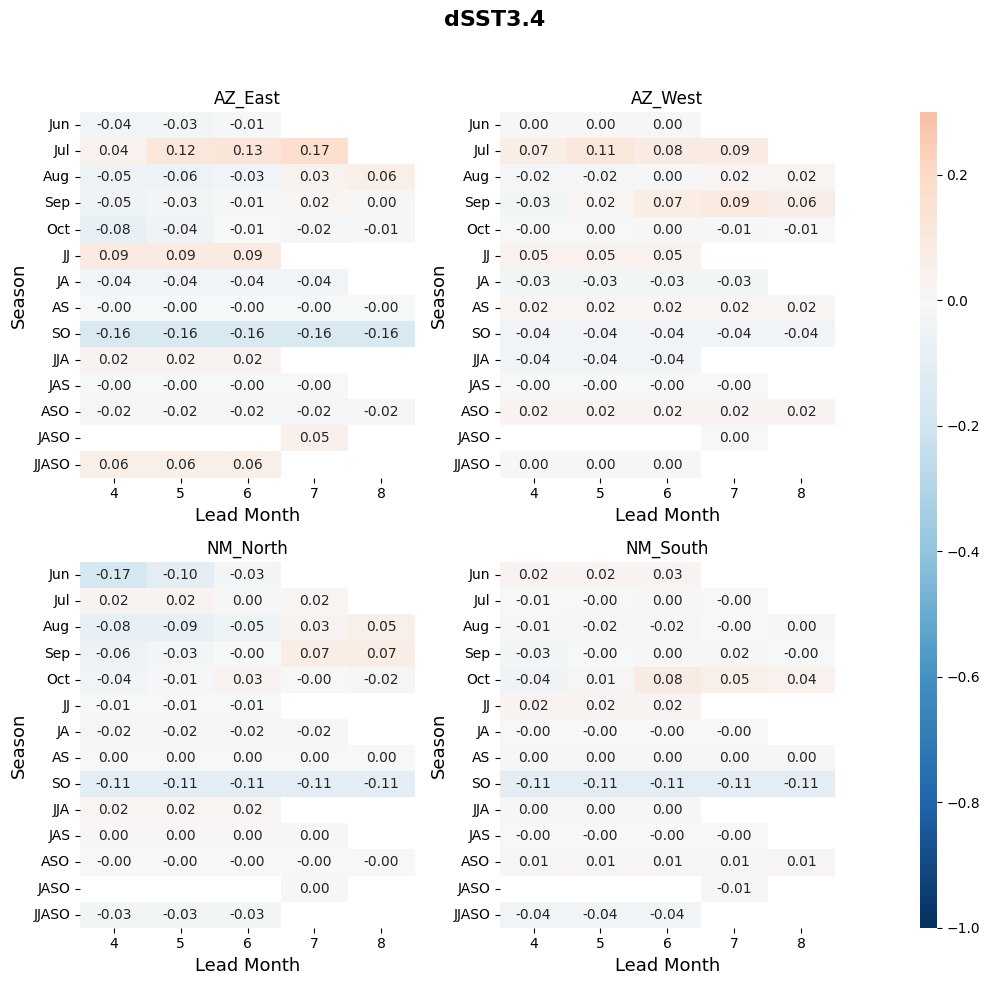

<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead

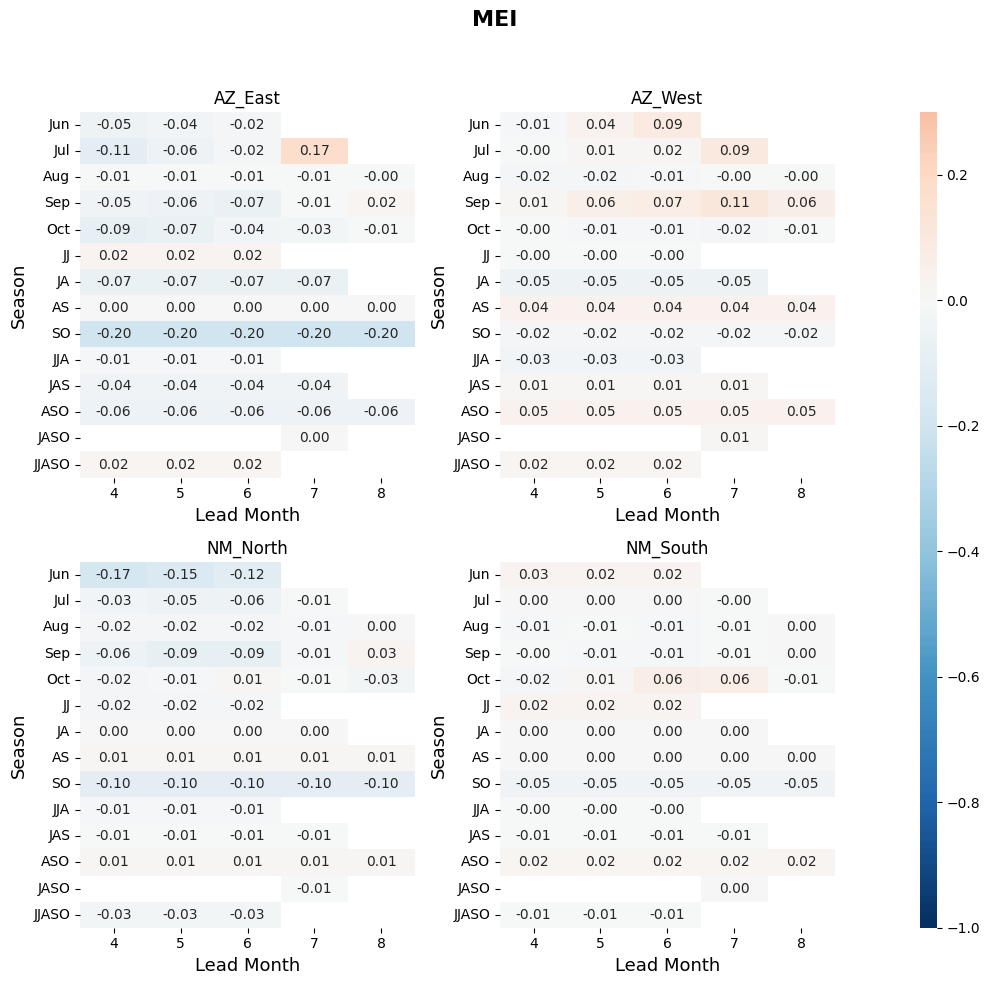

<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead

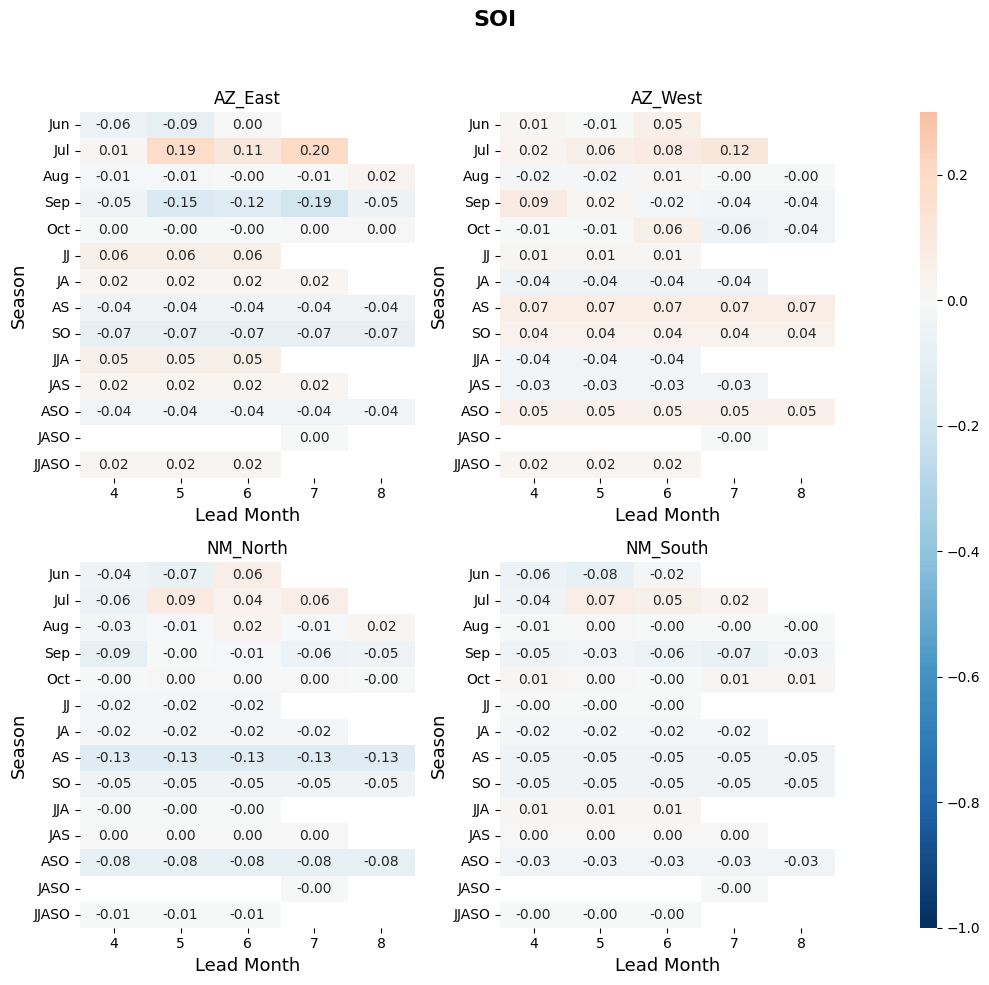

<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead

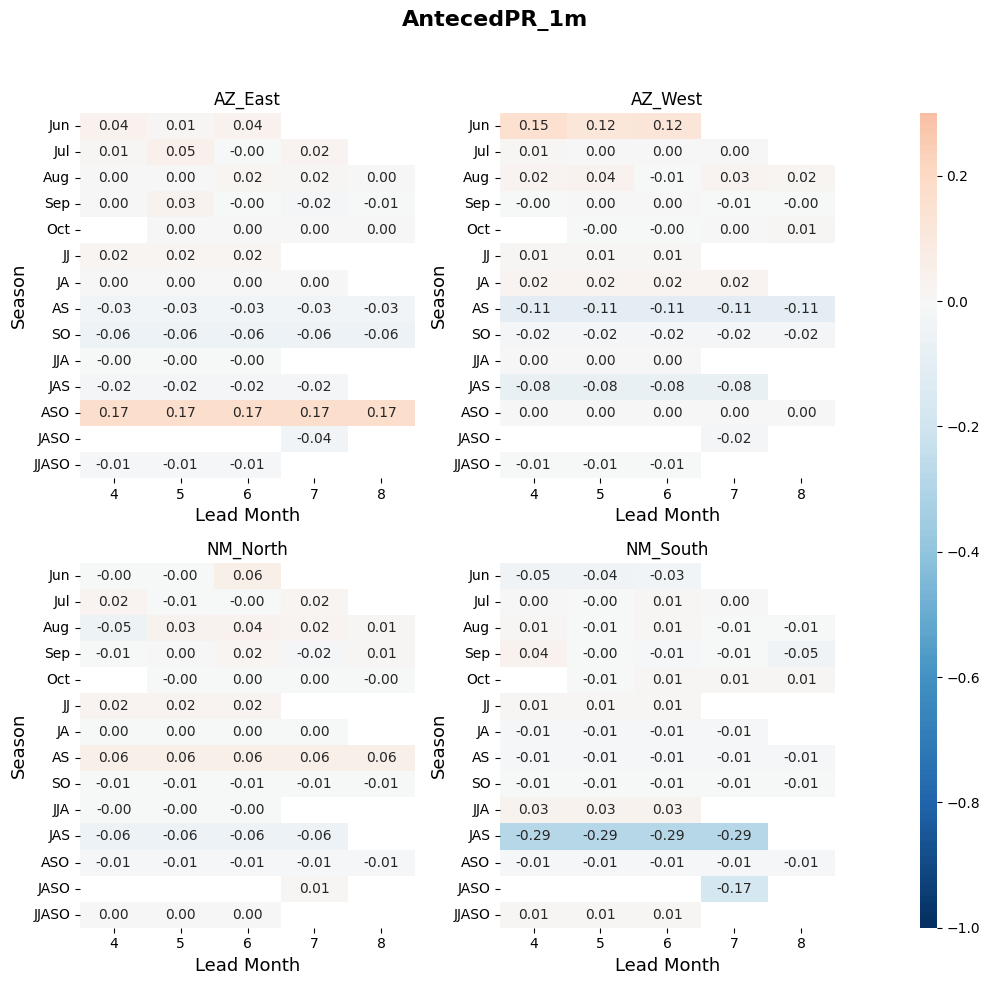

<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead

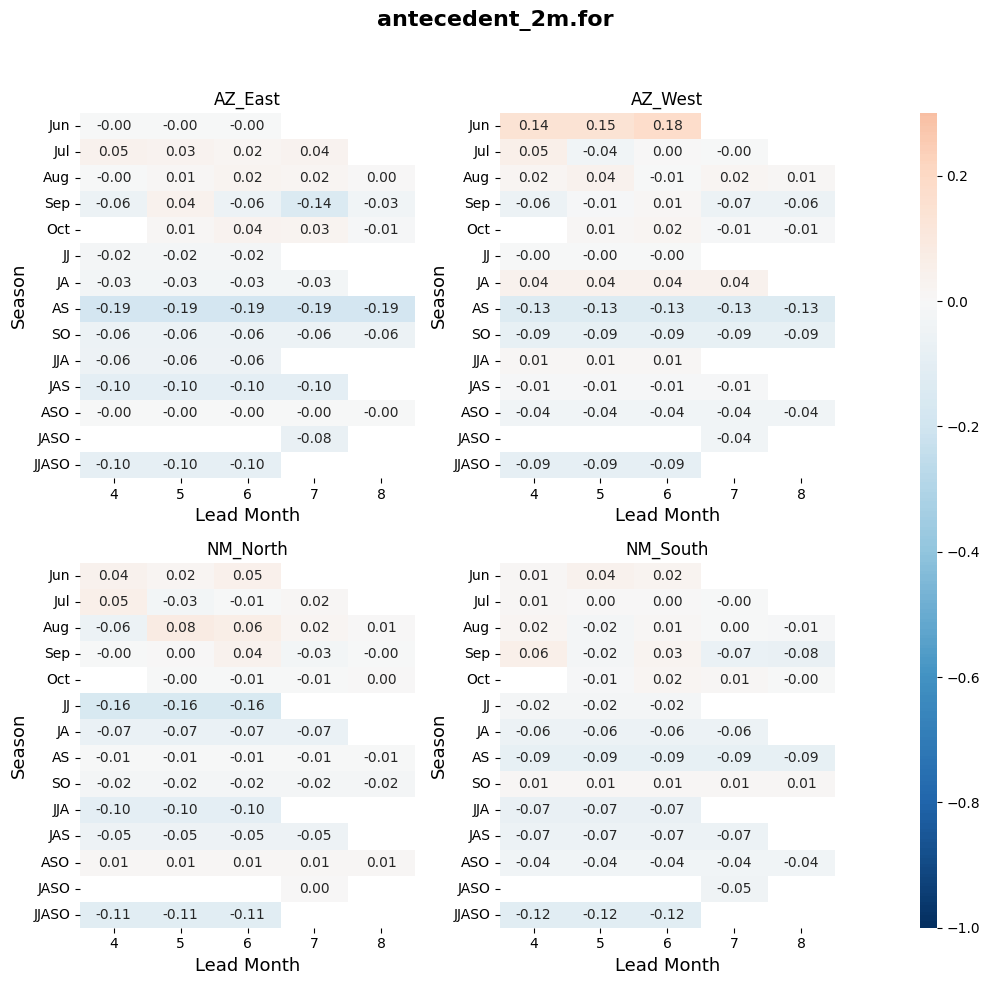

<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead

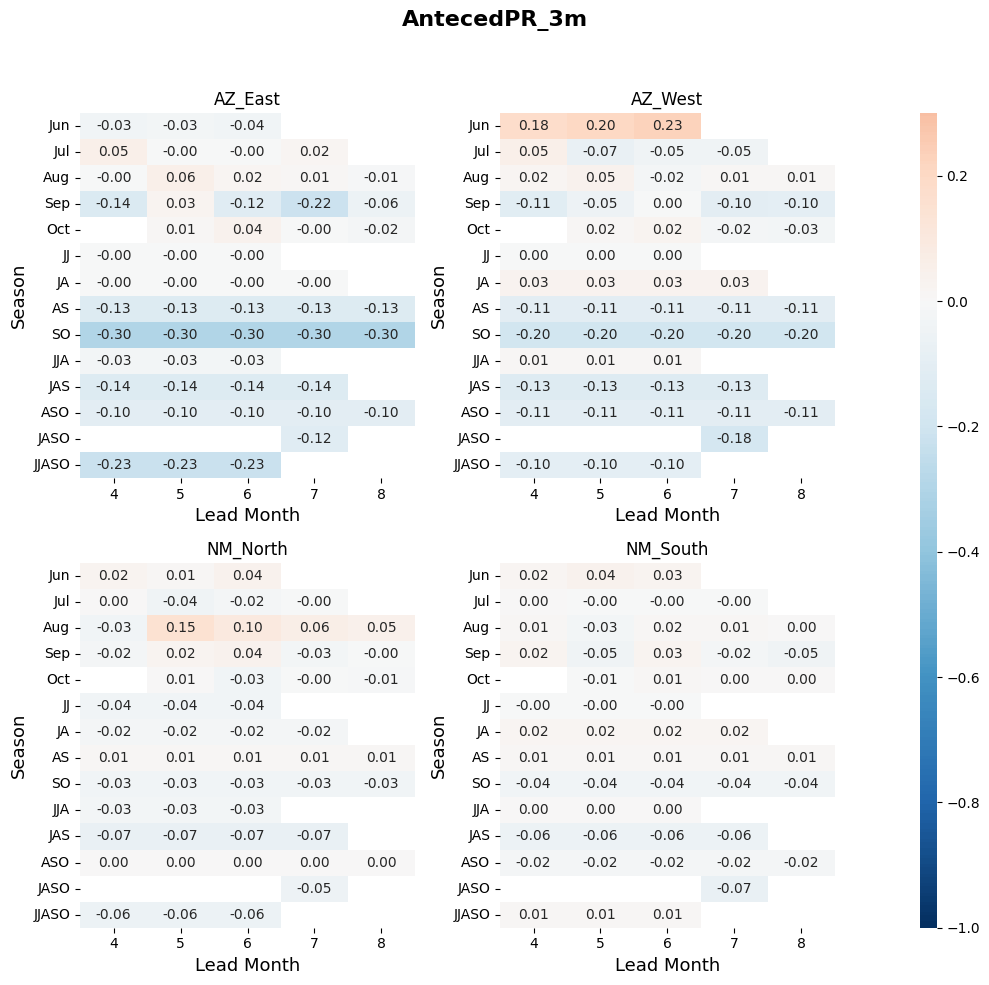

<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead

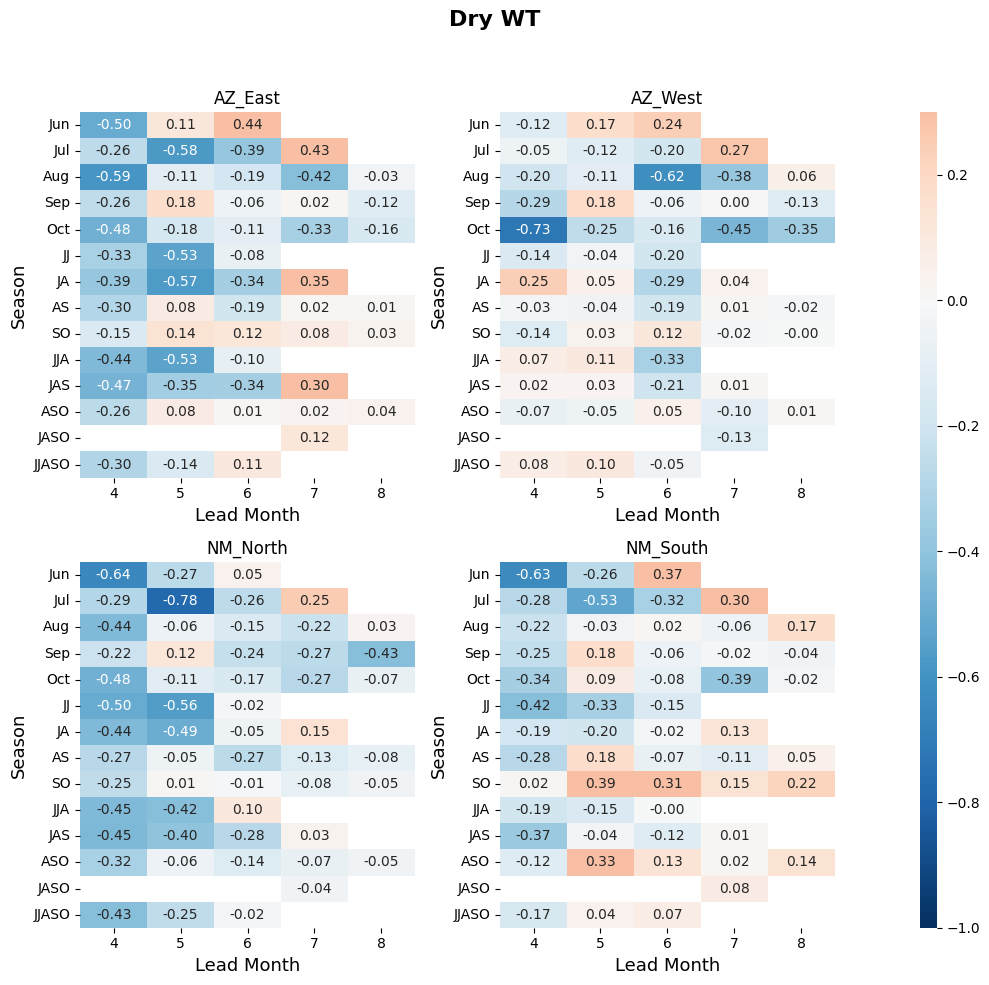

<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead

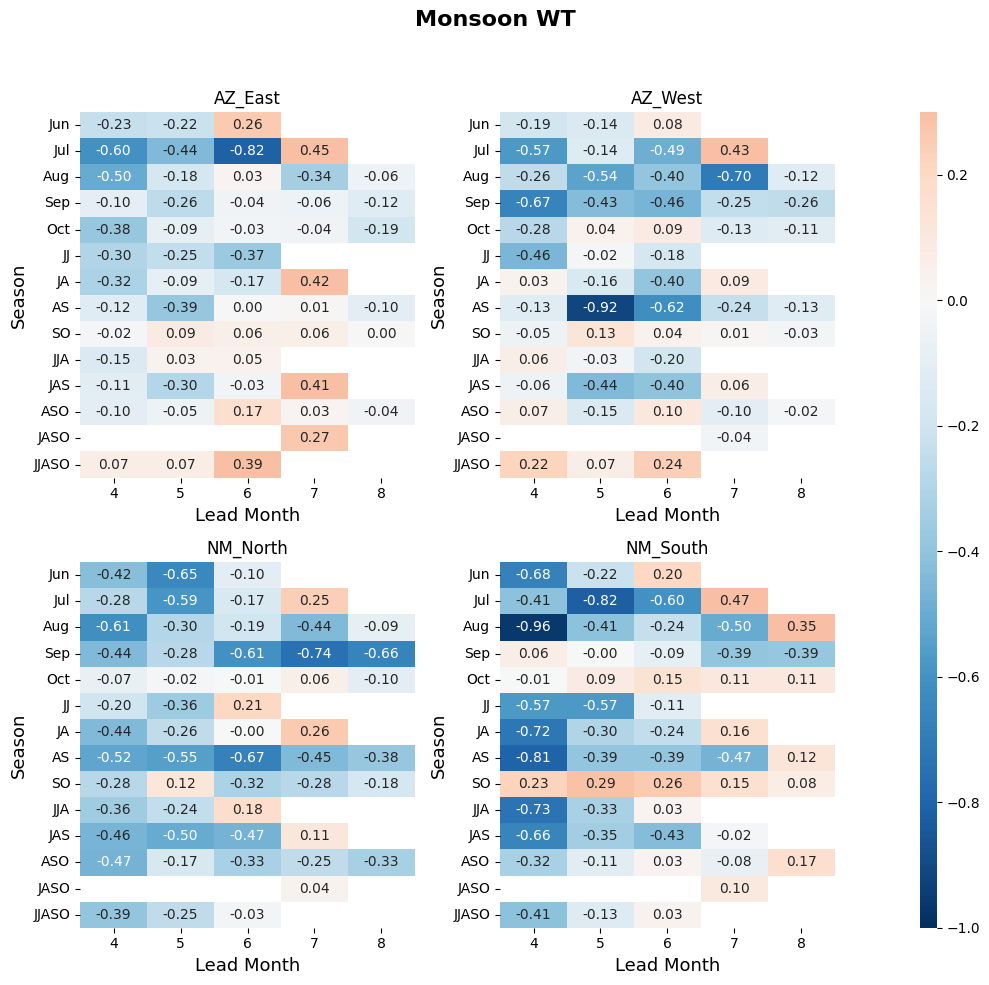

<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead

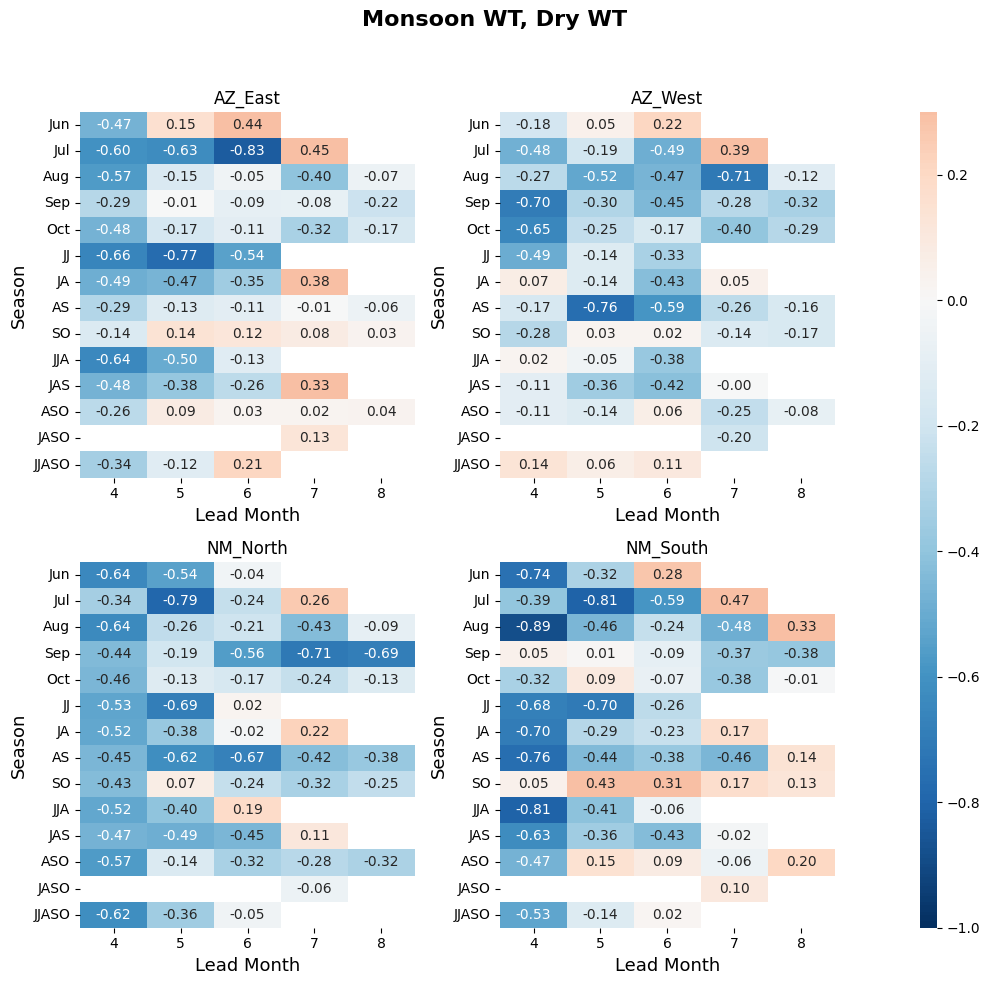

<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead

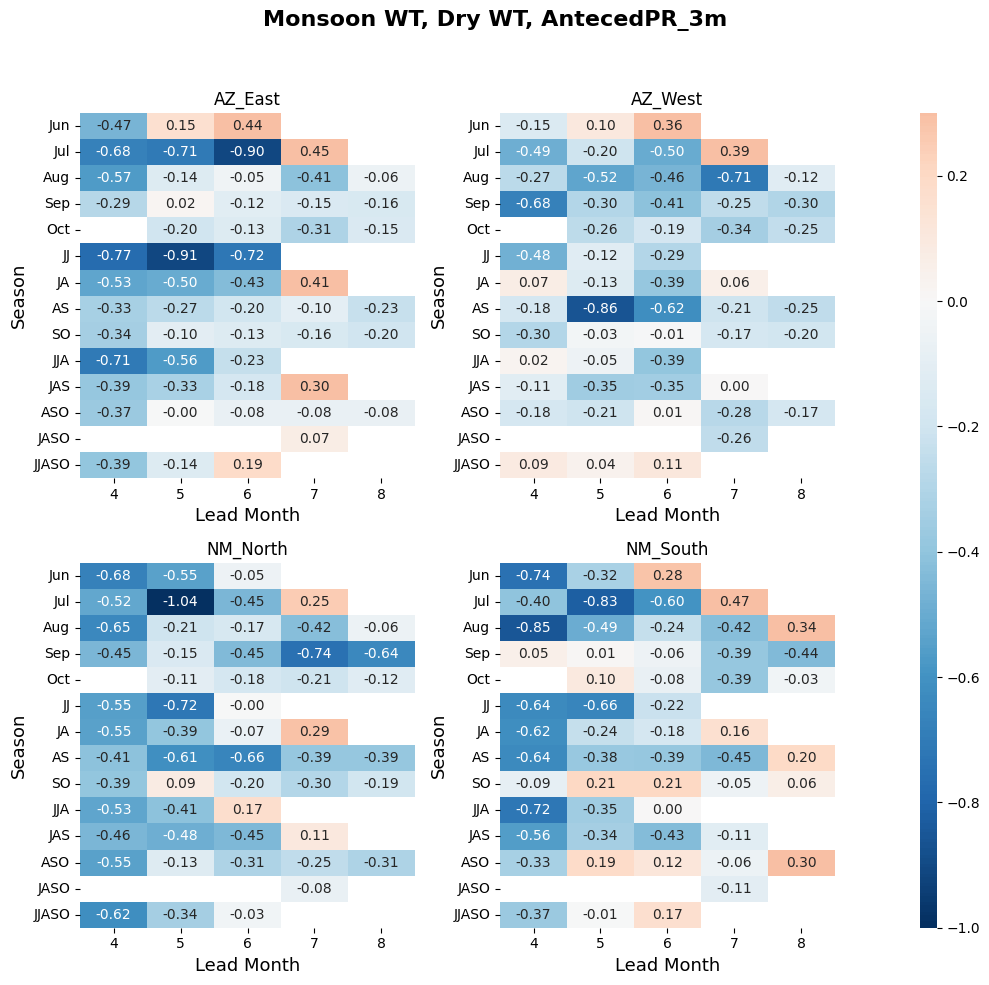

<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead

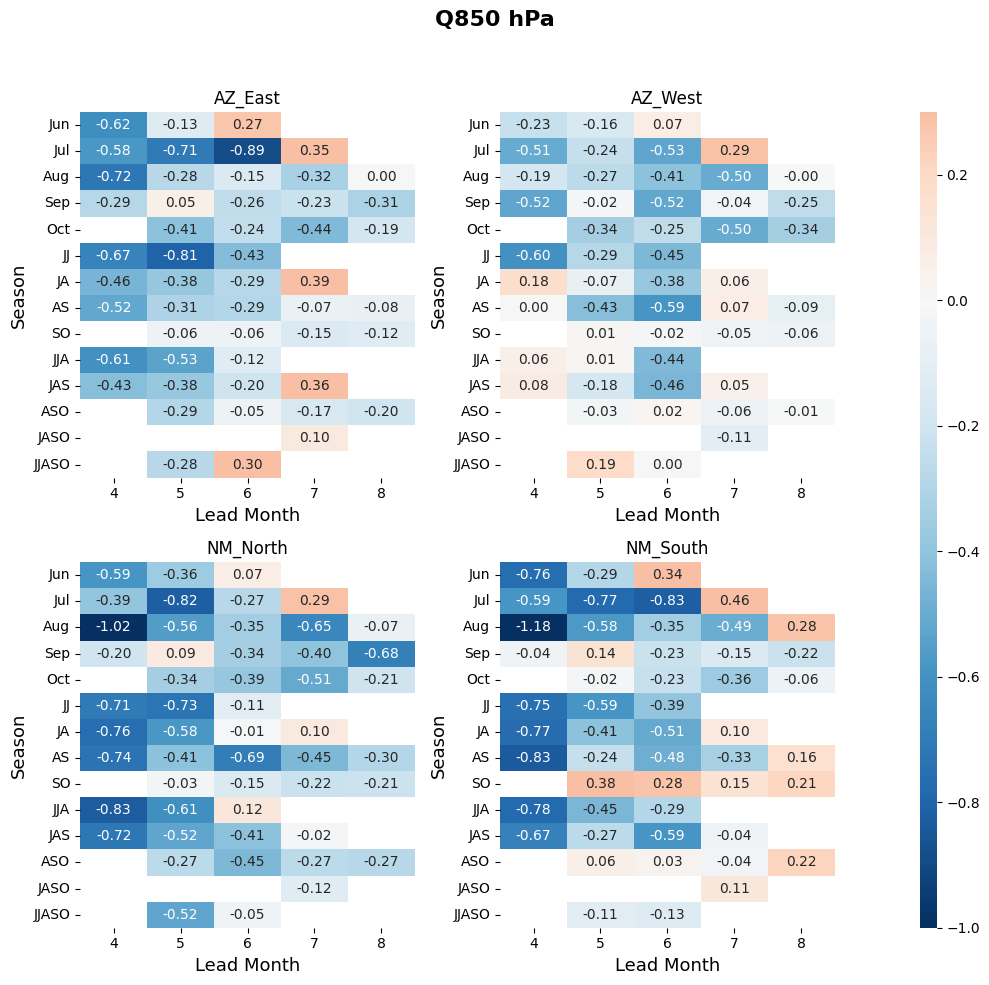

<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead

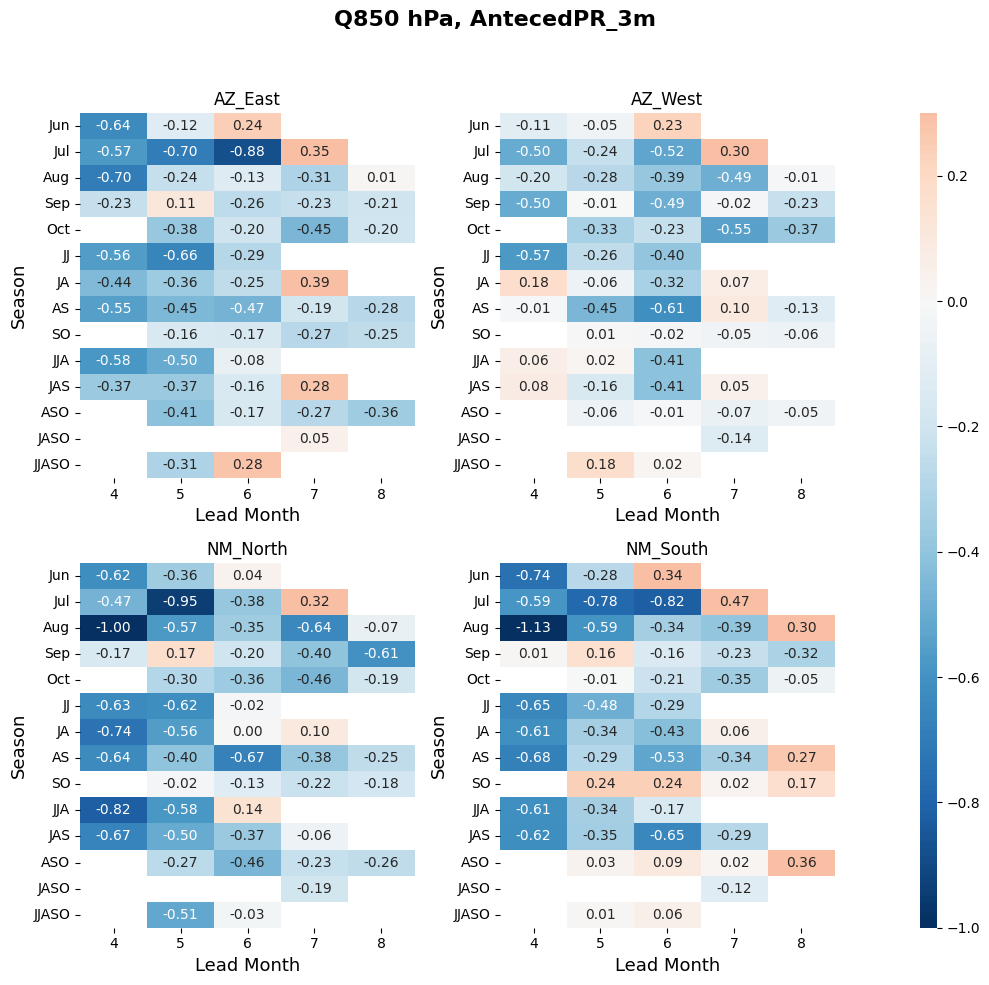

<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead

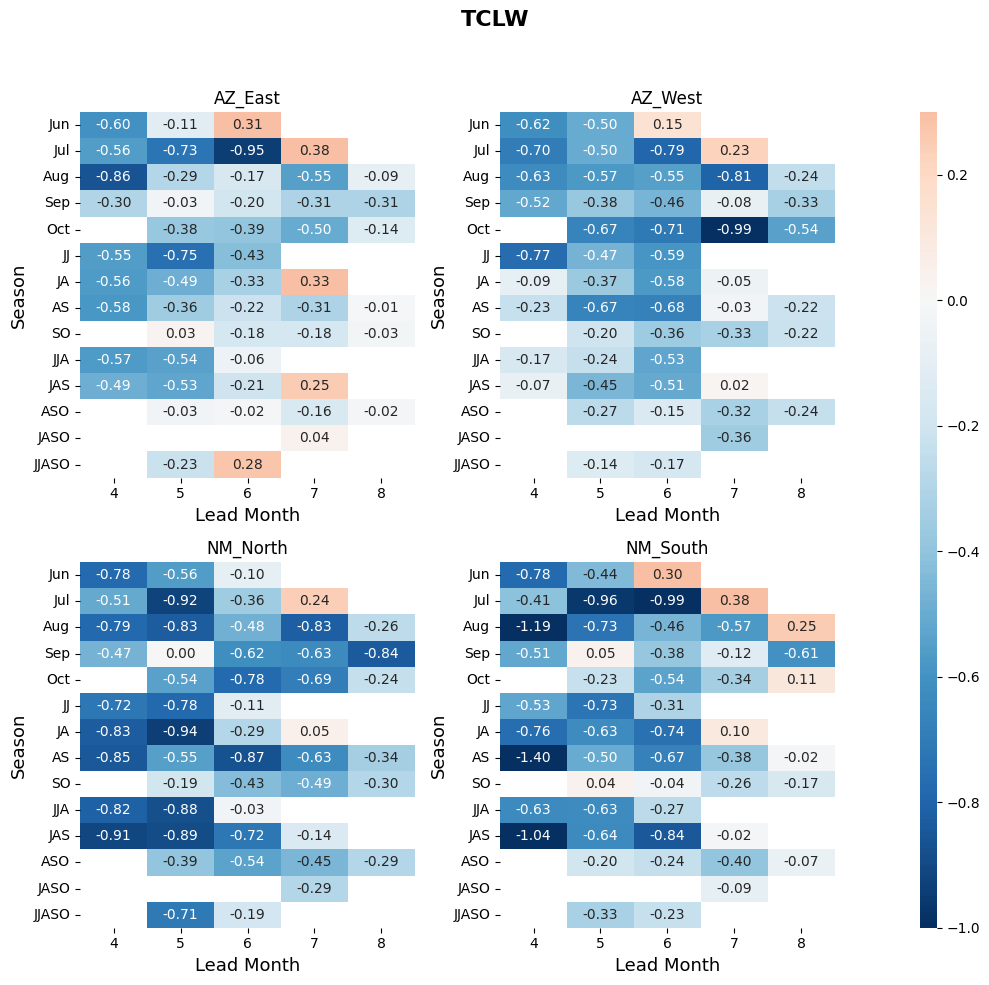

<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
<ipython-input-15-12bde3af6f4f>:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = df_region.pivot_table(index="season", columns="lead

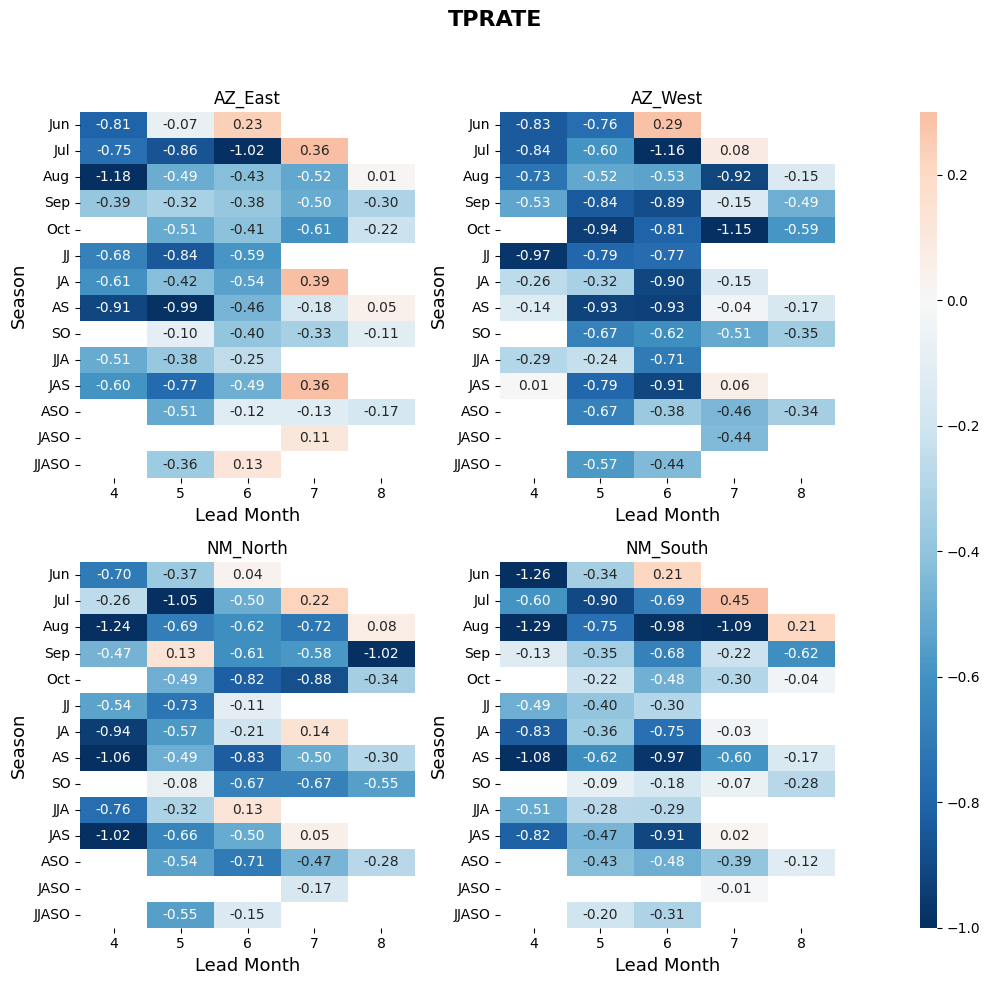

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.gridspec as gridspec

stat_to_plot = "R2"
predictors = sorted(gof_filtered["predictor"].dropna().unique())

predictor_label_map = {
    'ant_dsst3.4.for': "dSST3.4",
    'ant_mei.for': "MEI",
    'ant_soi.for': "SOI",
    "sumDry.for": "Dry WT",
    "sumMonsoon.for": "Monsoon WT",
    "sumq.for": "Q850 hPa",
    "antecedent_3m.for": "AntecedPR_3m",
    "antecedent_1m.for": "AntecedPR_1m",
    "sumtclw.for": "TCLW",
    "sumtprate.for": "TPRATE",
    "sumMonsoon.for+sumDry.for": "Monsoon WT, Dry WT",
    "sumMonsoon.for+sumDry.for+antecedent_3m.for": "Monsoon WT, Dry WT, AntecedPR_3m",
    "sumq.for+antecedent_3m.for": "Q850 hPa, AntecedPR_3m"
}

regions = sorted(gof_filtered["region"].dropna().unique())
n_rows = 2
n_cols = 2

for predictor in predictors:
    df_pred = gof_filtered[
        (gof_filtered["predictor"] == predictor) &
        (gof_filtered["stat"] == stat_to_plot)
    ]

    if df_pred.empty:
        continue

    friendly_name = predictor_label_map.get(predictor, predictor)

    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(f"{friendly_name}", fontsize=16, fontweight='bold')

    import matplotlib.gridspec as gridspec
    gs = gridspec.GridSpec(n_rows, n_cols + 1, width_ratios=[1, 1, 0.05])

    axes = []
    for i in range(n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        ax = fig.add_subplot(gs[row, col])
        axes.append(ax)

    cbar_ax = fig.add_subplot(gs[:, -1])

    for ax, region in zip(axes, regions):
        df_region = df_pred[df_pred["region"] == region]
        if df_region.empty:
            ax.axis("off")
            continue

        matrix = df_region.pivot_table(index="season", columns="lead_month", values="value", aggfunc="mean")
        matrix = matrix.reindex(custom_season_order)

        sns.heatmap(matrix, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
                    vmin=-1, vmax=0.3, ax=ax, cbar_ax=cbar_ax, cbar=True)

        ax.set_title(region)
        ax.set_xlabel("Lead Month", fontsize=13)
        ax.set_ylabel("Season", fontsize=13)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

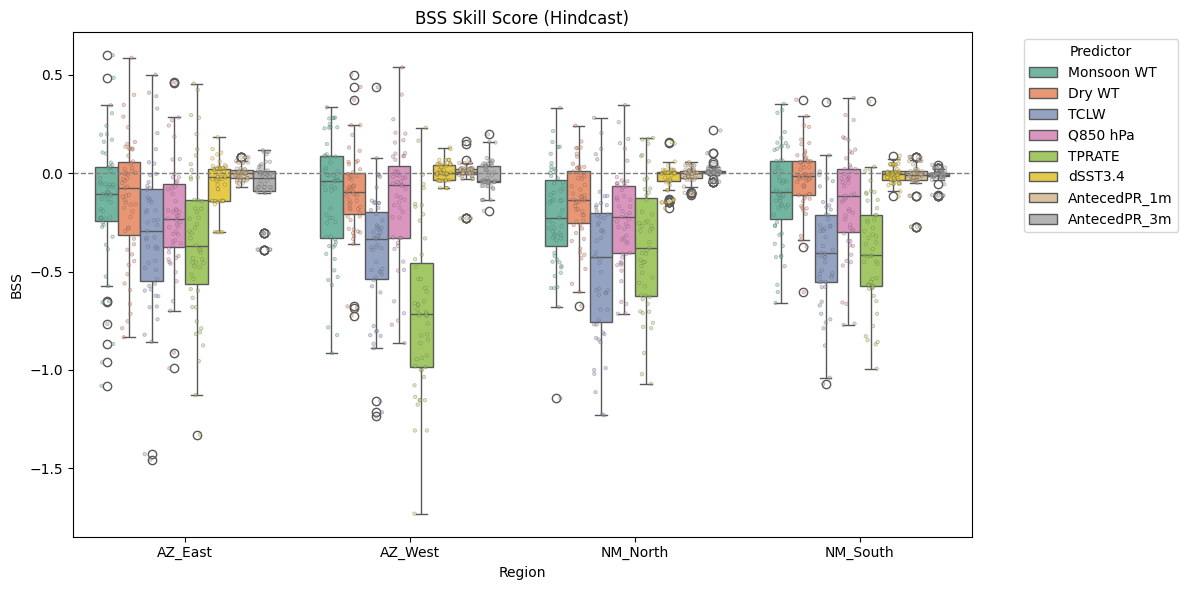

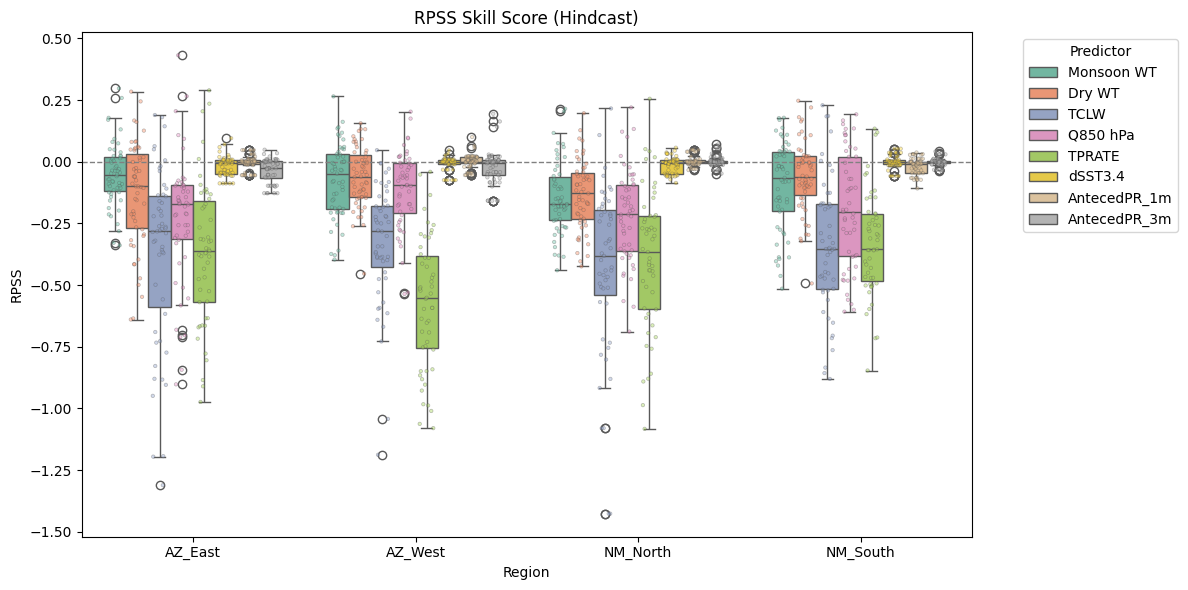

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Palette for predictors (reversed from original role)
predictors = box_df["predictor_label"].unique()
palette = sns.color_palette("Set2", len(predictors))

# Loop over stats
for stat in stats:
    df_plot = box_df[box_df["stat"] == stat]

    plt.figure(figsize=(12, 6))
    ax = plt.gca()

    # Boxplot: group by region, hue by predictor
    sns.boxplot(
        data=df_plot,
        x="region",
        y="value",
        hue="predictor_label",
        palette=palette,
        ax=ax
    )

    # Overlay jittered points
    sns.stripplot(
        data=df_plot,
        x="region",
        y="value",
        hue="predictor_label",
        dodge=True,
        jitter=0.25,
        marker='.',
        alpha=0.4,
        palette=palette,
        linewidth=0.5,
        ax=ax
    )

    # Fix duplicate legend
    handles, labels = ax.get_legend_handles_labels()
    n_predictors = len(predictors)
    ax.legend(handles[:n_predictors], labels[:n_predictors],
              title="Predictor", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Formatting
    plt.axhline(0, linestyle='--', color='gray', linewidth=1)
    plt.title(f"{stat} Skill Score (Hindcast)")
    plt.xlabel("Region")
    plt.ylabel(stat)
    plt.tight_layout()
    plt.show()


<ipython-input-23-d35b7b4d196e>:8: DtypeWarning: Columns (9,10,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  gof_filtered = pd.read_csv("gof_training_hindcast.csv")


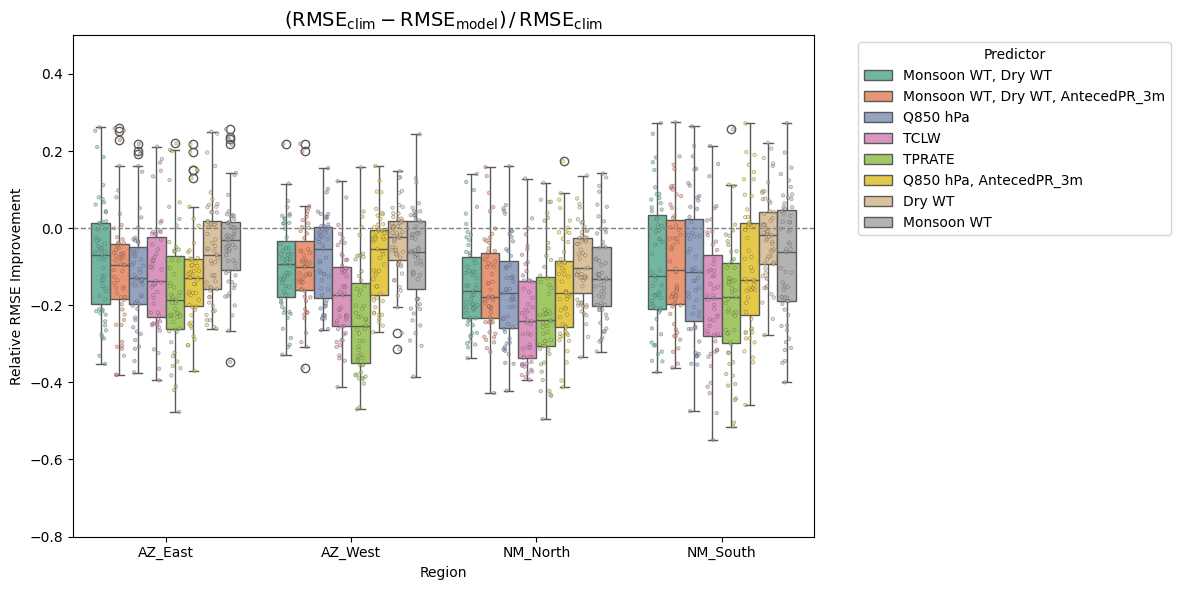

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Load the data
gof_filtered = pd.read_csv("gof_training_hindcast.csv")

# Define label map
predictor_map = {
    #'ant_dsst3.4.for': "dSST3.4",
    "sumDry.for": "Dry WT",
    "sumMonsoon.for": "Monsoon WT",
    "sumq.for": "Q850 hPa",
    #"antecedent_3m.for": "AntecedPR_3m",
    #"antecedent_1m.for": "AntecedPR_1m",
    "sumtclw.for": "TCLW",
    "sumtprate.for": "TPRATE",
    "sumMonsoon.for+sumDry.for": "Monsoon WT, Dry WT",
    "sumMonsoon.for+sumDry.for+antecedent_3m.for": "Monsoon WT, Dry WT, AntecedPR_3m",
    "sumq.for+antecedent_3m.for": "Q850 hPa, AntecedPR_3m"
}
target_predictors = list(predictor_map.keys())

ordered_labels = [
    "Monsoon WT, Dry WT",
    "Monsoon WT, Dry WT, AntecedPR_3m",
    "Q850 hPa",
    "TCLW",
    "TPRATE",
    "Q850 hPa, AntecedPR_3m",
    "Dry WT",
    "Monsoon WT"
]

# Filter relevant rows
rmse_data = gof_filtered[
    (gof_filtered["stat"] == "RMSE") &
    (gof_filtered["predictor"].isin(target_predictors)) &
    (gof_filtered["lead_month"].notna()) &
    (gof_filtered["model"].isin(["SLR", "MLR", "climatology"]))
].copy()

# Pivot to get RMSE for each model
pivot_df = rmse_data.pivot_table(
    index=["predictor", "region", "season", "lead_month"],
    columns="model",
    values="value"
).reset_index()

# Compute skill score
pivot_df["rmse_model"] = pivot_df[["SLR", "MLR"]].min(axis=1)
pivot_df["delta_rmse"] = pivot_df["climatology"] - pivot_df["rmse_model"]
pivot_df["rmse_skill_score"] = 1 - pivot_df["rmse_model"] / pivot_df["climatology"]

# Map predictor labels
pivot_df["predictor_label"] = pivot_df["predictor"].map(predictor_map)
pivot_df["predictor_label"] = pd.Categorical(
    pivot_df["predictor_label"],
    categories=ordered_labels,
    ordered=True
)

# Plot (grouped by region)
palette = sns.color_palette("Set2", len(ordered_labels))  # One color per predictor
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Boxplot
sns.boxplot(
    data=pivot_df,
    x="region",
    y="rmse_skill_score",
    hue="predictor_label",
    palette=palette,
    ax=ax
)

# Stripplot
sns.stripplot(
    data=pivot_df,
    x="region",
    y="rmse_skill_score",
    hue="predictor_label",
    dodge=True,
    jitter=0.25,
    marker='.',
    alpha=0.5,
    palette=palette,
    linewidth=0.5,
    ax=ax
)

# Legend cleanup
handles, labels = ax.get_legend_handles_labels()
n_predictors = len(ordered_labels)
ax.legend(handles[:n_predictors], labels[:n_predictors],
          title="Predictor", bbox_to_anchor=(1.05, 1), loc='upper left')

# Aesthetic adjustments
plt.axhline(0, linestyle='--', color='gray', linewidth=1)
ax.set_ylim(-0.8, 0.5)
plt.title(r"$(\mathrm{RMSE}_{\mathrm{clim}} - \mathrm{RMSE}_{\mathrm{model}}) \,/\, \mathrm{RMSE}_{\mathrm{clim}}$", fontsize=14)
plt.xlabel("Region")
plt.ylabel("Relative RMSE Improvement")
plt.tight_layout()
plt.show()
pivot_df.to_csv("pivot_df.csv", index=False)